In [87]:
from sklearn.cluster import DBSCAN
from imutils import build_montages, paths
import numpy as np
import os
import pickle
import cv2
import shutil
import time
import dlib
from pyPiper import Node, Pipeline
from tqdm import tqdm
import face_recognition

''' Common utilities '''
'''
Credits: AndyP at StackOverflow
The ResizeUtils provides resizing function to keep the aspect ratio intact
'''
class ResizeUtils:
    # Given a target height, adjust the image by calculating the width and resize
    def rescale_by_height(self, image, target_height, method=cv2.INTER_LANCZOS4):
        """Rescale `image` to `target_height` (preserving aspect ratio)."""
        w = int(round(target_height * image.shape[1] / image.shape[0]))
        return cv2.resize(image, (w, target_height), interpolation=method)

    # Given a target width, adjust the image by calculating the height and resize
    def rescale_by_width(self, image, target_width, method=cv2.INTER_LANCZOS4):
        """Rescale `image` to `target_width` (preserving aspect ratio)."""
        h = int(round(target_width * image.shape[0] / image.shape[1]))
        return cv2.resize(image, (target_width, h), interpolation=method)



''' Frames extractor from video footage '''
'''
The FramesGenerator extracts image frames from the given video file
The image frames are resized for dlib processing
'''
class FramesGenerator:
    def __init__(self, VideoFootageSource):
        self.VideoFootageSource = VideoFootageSource

    # Resize the given input to fit in a specified 
    # size for face embeddings extraction
    def AutoResize(self, frame):
        resizeUtils = ResizeUtils()

        height, width, _ = frame.shape

        if height > 500:
            frame = resizeUtils.rescale_by_height(frame, 500)
            self.AutoResize(frame)
        
        if width > 700:
            frame = resizeUtils.rescale_by_width(frame, 700)
            self.AutoResize(frame)
        
        return frame

    # Extract 1 frame from each second from video footage 
    # and save the frames to a specific folder
    def GenerateFrames(self, OutputDirectoryName):
        cap = cv2.VideoCapture(self.VideoFootageSource)
        _, frame = cap.read()

        fps = cap.get(cv2.CAP_PROP_FPS)
        TotalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

        print("[INFO] Total Frames ", TotalFrames, " @ ", fps, " fps")
        print("[INFO] Calculating number of frames per second")

        CurrentDirectory = os.path.curdir
        OutputDirectoryPath = os.path.join(CurrentDirectory, OutputDirectoryName)

        if os.path.exists(OutputDirectoryPath):
            shutil.rmtree(OutputDirectoryPath)
            time.sleep(0.5)
        os.mkdir(OutputDirectoryPath)

        CurrentFrame = 1
        fpsCounter = 0
        FrameWrittenCount = 1
        while CurrentFrame < TotalFrames:
            success, frame = cap.read()
            if not success:
                break
            
            if fpsCounter > fps:
                fpsCounter = 0

                frame = self.AutoResize(frame)
    
                filename = "frame_" + str(FrameWrittenCount) + ".jpg"
                cv2.imwrite(os.path.join(OutputDirectoryPath, filename), frame)

                FrameWrittenCount += 1
            if CurrentFrame % 50 == 0:
                print('got frame',CurrentFrame)
            fpsCounter += 1
            CurrentFrame += 1

        print('[INFO] Frames extracted')



''' Face clustering multithreaded pipeline '''
'''
Following are nodes for pipeline constructions. It will create and asynchronously
execute threads for reading images, extracting facial features and storing 
them independently in different threads
'''
# Keep emitting the filenames into the pipeline for processing
class FramesProvider(Node):
    def setup(self, sourcePath):
        self.sourcePath = sourcePath
        self.filesList = []
        for item in os.listdir(self.sourcePath):
            _, fileExt = os.path.splitext(item)
            if fileExt == '.jpg':
                self.filesList.append(os.path.join(item))
        self.TotalFilesCount = self.size = len(self.filesList)
        self.ProcessedFilesCount = self.pos = 0

    # Emit each filename in the pipeline for parallel processing
    def run(self, data):
        if self.ProcessedFilesCount < self.TotalFilesCount:
            self.emit({'id': self.ProcessedFilesCount, 
                'imagePath': os.path.join(self.sourcePath, 
                                self.filesList[self.ProcessedFilesCount])})
            self.ProcessedFilesCount += 1
            
            self.pos = self.ProcessedFilesCount
        else:
            self.close()

# Encode the face embedding, reference path and location 
# and emit to pipeline
class FaceEncoder(Node):
    def setup(self, detection_method = 'cnn'):
        self.detection_method = detection_method
        # detection_method can be cnn or hog

    def run(self, data):
        id = data['id']
        imagePath = data['imagePath']
        image = cv2.imread(imagePath)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes = face_recognition.face_locations(rgb, model=self.detection_method)
        encodings = face_recognition.face_encodings(rgb, boxes)
        d = [{"imagePath": imagePath, "loc": box, "encoding": enc} 
                for (box, enc) in zip(boxes, encodings)]

        self.emit({'id': id, 'encodings': d})

# Recieve the face embeddings for clustering and 
# id for naming the distinct filename
class DatastoreManager(Node):
    def setup(self, encodingsOutputPath):
        self.encodingsOutputPath = encodingsOutputPath
    def run(self, data):
        encodings = data['encodings']
        id = data['id']
        with open(os.path.join(self.encodingsOutputPath, 
                            'encodings_' + str(id) + '.pickle'), 'wb') as f:
            f.write(pickle.dumps(encodings))

# Inherit class tqdm for visualization of progress
class TqdmUpdate(tqdm):
    # This function will be passed as progress callback function
    # Setting the predefined variables for auto-updates in visualization
    def update(self, done, total_size=None):
        if total_size is not None:
            self.total = total_size
        self.n = done
        super().refresh()



''' Pickle files merging '''
'''
PicklesListCollator takes multiple pickle files as input and merge them together
It is made specifically to support our use-case of merging distinct pickle
files into one
'''
class PicklesListCollator:
    def __init__(self, picklesInputDirectory):
        self.picklesInputDirectory = picklesInputDirectory
    
    # Here we will list down all the pickles files generated from 
    # multiple threads, read the list of results
    # append them to a common list and create another pickle
    # with combined list as content
    def GeneratePickle(self, outputFilepath):
        datastore = []

        ListOfPickleFiles = []
        for item in os.listdir(self.picklesInputDirectory):
            _, fileExt = os.path.splitext(item)
            if fileExt == '.pickle':
                ListOfPickleFiles.append(os.path.join(self.picklesInputDirectory, item))

        for picklePath in ListOfPickleFiles:
            with open(picklePath, "rb") as f:
                data = pickle.loads(f.read())
                datastore.extend(data)

        with open(outputFilepath, 'wb') as f:
            f.write(pickle.dumps(datastore))



''' Face clustering functionality '''
class FaceClusterUtility:
	def __init__(self, EncodingFilePath):
		self.EncodingFilePath = EncodingFilePath
	
    # Credits: Arian's pyimagesearch for the clustering code
    # Here we are using the sklearn.DBSCAN functioanlity
    # cluster all the facial embeddings to get clusters 
    # representing distinct people
	def Cluster(self):
		InputEncodingFile = self.EncodingFilePath
		if not (os.path.isfile(InputEncodingFile) and os.access(InputEncodingFile, os.R_OK)):
			print('The input encoding file, ' + 
                    str(InputEncodingFile) + ' does not exists or unreadable')
			exit()

		NumberOfParallelJobs = -1

		# load the serialized face encodings + bounding box locations from
		# disk, then extract the set of encodings to so we can cluster on
		# them
		print("[INFO] Loading encodings")
		data = pickle.loads(open(InputEncodingFile, "rb").read())
		data = np.array(data)

		encodings = [d["encoding"] for d in data]

		# cluster the embeddings
		print("[INFO] Clustering")
		clt = DBSCAN(eps=0.5, metric="euclidean", n_jobs=NumberOfParallelJobs)
		clt.fit(encodings)

		# determine the total number of unique faces found in the dataset
		labelIDs = np.unique(clt.labels_)
		numUniqueFaces = len(np.where(labelIDs > -1)[0])
		print("[INFO] # unique faces: {}".format(numUniqueFaces))

		return clt.labels_

class FaceImageGenerator:
	def __init__(self, EncodingFilePath):
		self.EncodingFilePath = EncodingFilePath

    # Credits: Adrian's pyimagesearch for reference codes
    # Here we are creating montages for first 25 faces for each 
    # distinct face. 
    # We will also generate images for all the distinct faces by using the 
    # labels from clusters and image url from the encodings pickle 
    # file.
    
    # The face bounding box is increased a little more for 
    # training purposes and we also created the exact 
    # annotation for each face image (similar to darknet YOLO)
    # to easily adapt the annotation for future use in supervised training
	def GenerateImages(self, labels, OutputFolderName = "ClusteredFaces", 
                                            MontageOutputFolder = "Montage"):
		output_directory = os.getcwd()

		OutputFolder = os.path.join(output_directory, OutputFolderName)
		if not os.path.exists(OutputFolder):
			os.makedirs(OutputFolder)
		else:
			shutil.rmtree(OutputFolder)
			time.sleep(0.5)
			os.makedirs(OutputFolder)

		MontageFolderPath = os.path.join(OutputFolder, MontageOutputFolder)
		os.makedirs(MontageFolderPath)

		data = pickle.loads(open(self.EncodingFilePath, "rb").read())
		data = np.array(data)

		labelIDs = np.unique(labels)
		# loop over the unique face integers
		for labelID in labelIDs:
			# find all indexes into the `data` array that belong to the
			# current label ID, then randomly sample a maximum of 25 indexes
			# from the set
			
			print("[INFO] faces for face ID: {}".format(labelID))

			FaceFolder = os.path.join(OutputFolder, "Face_" + str(labelID))
			os.makedirs(FaceFolder)

			idxs = np.where(labels == labelID)[0]

			# initialize the list of faces to include in the montage
			portraits = []

			# loop over the sampled indexes
			counter = 1
			for i in idxs:
				# load the input image and extract the face ROI
				image = cv2.imread(data[i]["imagePath"])
				(o_top, o_right, o_bottom, o_left) = data[i]["loc"]

				height, width, channel = image.shape

				widthMargin = 100
				heightMargin = 150

				top = o_top - heightMargin
				if top < 0:
					top = 0
				
				bottom = o_bottom + heightMargin
				if bottom > height:
					bottom = height
				
				left = o_left - widthMargin
				if left < 0:
					left = 0
				
				right = o_right + widthMargin
				if right > width:
					right = width

				portrait = image[top:bottom, left:right]

				if len(portraits) < 25:
					portraits.append(portrait)

				resizeUtils = ResizeUtils()
				portrait = resizeUtils.rescale_by_width(portrait, 400)

				FaceFilename = "face_" + str(counter) + ".jpg"

				FaceImagePath = os.path.join(FaceFolder, FaceFilename)
				cv2.imwrite(FaceImagePath, portrait)





				widthMargin = 20
				heightMargin = 20

				top = o_top - heightMargin
				if top < 0:
					top = 0
				
				bottom = o_bottom + heightMargin
				if bottom > height:
					bottom = height
				
				left = o_left - widthMargin
				if left < 0:
					left = 0
				
				right = o_right + widthMargin
				if right > width:
					right = width

				AnnotationFilename = "face_" + str(counter) + ".txt"
				AnnotationFilePath = os.path.join(FaceFolder, AnnotationFilename)
				
				f = open(AnnotationFilePath, 'w')
				f.write(str(labelID) + ' ' + 
                        str(left) + ' ' + str(top) + ' ' + 
                        str(right) + ' ' + str(bottom) + "\n")
				f.close()


				counter += 1

			montage = build_montages(portraits, (96, 120), (5, 5))[0]
			
			MontageFilenamePath = os.path.join(MontageFolderPath, "Face_" + str(labelID) + ".jpg")
			cv2.imwrite(MontageFilenamePath, montage)



In [10]:
from collections import defaultdict
from sklearn.cluster import DBSCAN
from imutils import build_montages, paths
import numpy as np
import os
import pickle
import cv2
import shutil
import time
import dlib
from pyPiper import Node, Pipeline
from tqdm import tqdm
import face_recognition
from PIL import Image

def rescale_by_height(self, image, target_height, method=cv2.INTER_LANCZOS4):
    """Rescale `image` to `target_height` (preserving aspect ratio)."""
    w = int(round(target_height * image.shape[1] / image.shape[0]))
    return cv2.resize(image, (w, target_height), interpolation=method)

# Given a target width, adjust the image by calculating the height and resize
def rescale_by_width(self, image, target_width, method=cv2.INTER_LANCZOS4):
    """Rescale `image` to `target_width` (preserving aspect ratio)."""
    h = int(round(target_width * image.shape[0] / image.shape[1]))
    return cv2.resize(image, (target_width, h), interpolation=method)

def auto_resize(frame):

    height, width, _ = frame.shape

    if height > 500:
        frame = rescale_by_height(frame, 500)
        auto_resize(frame)
    
    if width > 700:
        frame = rescale_by_width(frame, 700)
        auto_resize(frame)
    
    return frame
    
def extract_encodings(images_dir):
    print("Extract Encodings")
    res = []
    for id, image_path in enumerate(paths.list_images(images_dir)):
        image = cv2.imread(image_path)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes = face_recognition.face_locations(rgb, model='cnn')
        encodings = face_recognition.face_encodings(rgb, boxes)
        d = [{"image_path": image_path, "loc": box, "encoding": enc} 
                for (box, enc) in zip(boxes, encodings)]

        res.append({'id': id, 'encodings': d})
        print('extract', id)
    print("DONE")
    return res

def generate_frames(video_path, frames_dir):
    cap = cv2.VideoCapture(video_path)
    _, frame = cap.read()

    fps = cap.get(cv2.CAP_PROP_FPS)
    TotalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    print("[INFO] Total Frames ", TotalFrames, " @ ", fps, " fps")
    print("[INFO] Calculating number of frames per second")

    if os.path.exists(frames_dir):
        shutil.rmtree(frames_dir)
        time.sleep(0.5)
    os.mkdir(frames_dir)

    CurrentFrame = 1
    fpsCounter = 0
    FrameWrittenCount = 1
    while CurrentFrame < TotalFrames:
        success, frame = cap.read()
        if not success:
            break
        
        if fpsCounter > fps:
            fpsCounter = 0

            frame = auto_resize(frame)

            filename = "frame_" + str(FrameWrittenCount) + ".jpg"
            cv2.imwrite(os.path.join(frames_dir, filename), frame)

            FrameWrittenCount += 1
        if CurrentFrame % 50 == 0:
            print('got frame',CurrentFrame)
        fpsCounter += 1
        CurrentFrame += 1

    print('[INFO] Frames extracted')

def encodings_to_pkl(data,encodings_dir):
    for d in data:
        encodings = d['encodings']
        id = d['id']
        with open(os.path.join(encodings_dir, 
                            'encodings_' + str(id) + '.pickle'), 'wb') as f:
            f.write(pickle.dumps(encodings))

def generate_pkl(encodings_dir, pickle_path):
    datastore = []

    pickle_paths = []
    for item in os.listdir(encodings_dir):
        _, fileExt = os.path.splitext(item)
        if fileExt == '.pickle':
            pickle_paths.append(os.path.join(encodings_dir, item))

    for picklePath in pickle_paths:
        with open(picklePath, "rb") as f:
            data = pickle.loads(f.read())
            datastore.extend(data)

    with open(pickle_path, 'wb') as f:
        f.write(pickle.dumps(datastore))

In [11]:
video_path = "video.mp4"
frames_dir = "frames"
encodings_dir = "encodings"
generate_frames(video_path, frames_dir)

[INFO] Total Frames  1861.0  @  29.97002997002997  fps
[INFO] Calculating number of frames per second
got frame 50
got frame 100
got frame 150
got frame 200
got frame 250
got frame 300
got frame 350
got frame 400
got frame 450
got frame 500
got frame 550
got frame 600
got frame 650
got frame 700
got frame 750
got frame 800
got frame 850
got frame 900
got frame 950
got frame 1000
got frame 1050
got frame 1100
got frame 1150
got frame 1200
got frame 1250
got frame 1300
got frame 1350
got frame 1400
got frame 1450
got frame 1500
got frame 1550
got frame 1600
got frame 1650
got frame 1700
got frame 1750
got frame 1800
got frame 1850
[INFO] Frames extracted


## Encode

In [12]:
encoding_file_path = "encodings.pickle"
encodings = extract_encodings(frames_dir)
encodings_to_pkl(encodings,encodings_dir)
generate_pkl(encodings_dir,encoding_file_path)

Extract Encodings
extract 0
extract 1
extract 2
extract 3
extract 4
extract 5
extract 6
extract 7
extract 8
extract 9
extract 10
extract 11
extract 12
extract 13
extract 14
extract 15
extract 16
extract 17
extract 18
extract 19
extract 20
extract 21
extract 22
extract 23
extract 24
extract 25
extract 26
extract 27
extract 28
extract 29
extract 30
extract 31
extract 32
extract 33
extract 34
extract 35
extract 36
extract 37
extract 38
extract 39
extract 40
extract 41
extract 42
extract 43
extract 44
extract 45
extract 46
extract 47
extract 48
extract 49
extract 50
extract 51
extract 52
extract 53
extract 54
extract 55
extract 56
extract 57
extract 58
extract 59
extract 60
DONE


FileNotFoundError: [Errno 2] No such file or directory: 'encodings/encodings_0.pickle'

## Cluster

[INFO] # unique faces: 6
Label 0


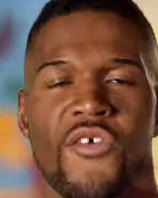

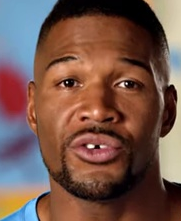

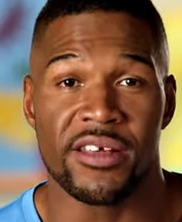

Label 2


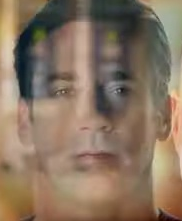

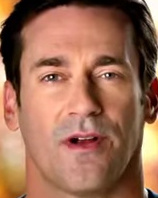

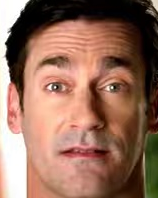

Label 1


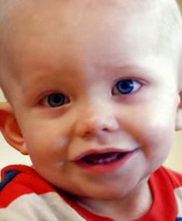

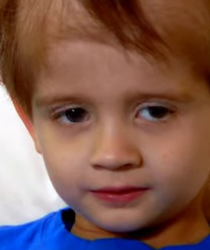

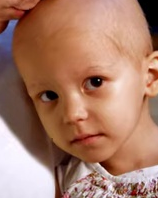

Label 3


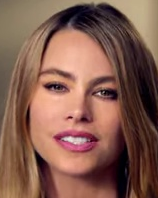

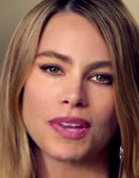

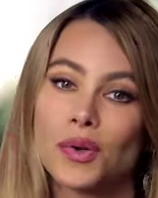

Label 4


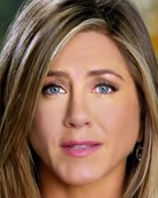

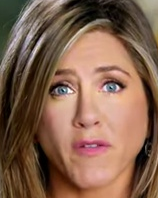

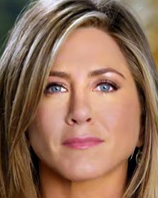

Label 5


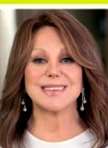

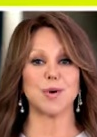

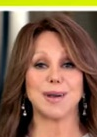

In [6]:
data = pickle.loads(open(encoding_file_path, "rb").read())
encodings = [d["encoding"] for d in data]
clt = DBSCAN(eps=0.5, metric="euclidean", n_jobs=-1)
clt.fit(encodings)

# determine the total number of unique faces found in the dataset
label_ids = np.unique(clt.labels_)
unique_face_count = len(np.where(label_ids > -1)[0])
print("[INFO] # unique faces: {}".format(unique_face_count))


# build up face dict
faces = defaultdict(lambda:[])
for label, val in zip(clt.labels_, data):
    if label < 0: continue
    faces[label].append({
        "image_path":val['image_path'],
        "loc":val["loc"]
    })

# list faces
for label in faces.keys():
    print("Label", label)
    for val in faces[label][:3]:
        image = cv2.imread(val['image_path'])
        padding = 20

        height, width, channel = image.shape
        
        o_top, o_right, o_bottom, o_left = val['loc']
        
        widthMargin = 20
        heightMargin = 40
        
        top = o_top - heightMargin
        if top < 0:
            top = 0
        bottom = o_bottom + heightMargin
        if bottom > height:
            bottom = height
        left = o_left - widthMargin
        if left < 0:
            left = 0
        right = o_right + widthMargin
        if right > width:
            right = width

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cropped_face = image[top:bottom, left:right]
        
        display(Image.fromarray(cropped_face))


[array([-0.22391386,  0.09279363,  0.13462317,  0.00972665, -0.06993398,
        -0.07559542,  0.06879093, -0.06856345,  0.12203006,  0.00083805,
         0.30627158, -0.03125819, -0.18469714, -0.2086775 ,  0.0859059 ,
         0.12458648, -0.13212177, -0.11135253, -0.05237378, -0.12741634,
         0.04646114, -0.05712106, -0.0445002 ,  0.03866504, -0.1546936 ,
        -0.3104167 , -0.05303793, -0.12137422,  0.1253309 , -0.10091443,
        -0.02927622,  0.108629  , -0.17419639, -0.1234178 , -0.05245021,
         0.10923973,  0.08468077, -0.0392698 ,  0.10309979, -0.07396736,
        -0.11612272, -0.04969505,  0.04828271,  0.28553677,  0.16503084,
        -0.0088255 ,  0.05006799,  0.10988414,  0.08839045, -0.20032671,
         0.05237027,  0.06872809,  0.19093741,  0.04517852,  0.06158264,
        -0.12915213, -0.07185373,  0.10390991, -0.15115635,  0.05587672,
         0.05478176, -0.10800691, -0.09403023, -0.11275282,  0.25566059,
         0.05570133, -0.10807938, -0.06250656,  0.1

## Get Faces

In [120]:
labelIDs = np.unique(labels)
# loop over the unique face integers
for labelID in labelIDs:
    labelID

NameError: name 'labels' is not defined

In [84]:
''' Generate the frames from given video footage '''
framesGenerator = FramesGenerator("video.mp4")
framesGenerator.GenerateFrames("Frames")


''' Design and run the face clustering pipeline '''
CurrentPath = os.getcwd()
FramesDirectory = "Frames"
FramesDirectoryPath = os.path.join(CurrentPath, FramesDirectory)
EncodingsFolder = "Encodings"
EncodingsFolderPath = os.path.join(CurrentPath, EncodingsFolder)

if os.path.exists(EncodingsFolderPath):
    shutil.rmtree(EncodingsFolderPath, ignore_errors=True)
    time.sleep(0.5)
os.makedirs(EncodingsFolderPath)

pipeline = Pipeline(
                FramesProvider("Files source", sourcePath=FramesDirectoryPath) | 
                FaceEncoder("Encode faces") | 
                DatastoreManager("Store encoding", 
                encodingsOutputPath=EncodingsFolderPath), 
                n_threads = 3, quiet = True)
pbar = TqdmUpdate()
pipeline.run(update_callback=pbar.update)

print()
print('[INFO] Encodings extracted')


''' Merge all the encodings pickle files into one '''
CurrentPath = os.getcwd()
EncodingsInputDirectory = "Encodings"
EncodingsInputDirectoryPath = os.path.join(CurrentPath, EncodingsInputDirectory)

OutputEncodingPickleFilename = "encodings.pickle"

if os.path.exists(OutputEncodingPickleFilename):
    os.remove(OutputEncodingPickleFilename)

picklesListCollator = PicklesListCollator(EncodingsInputDirectoryPath)
picklesListCollator.GeneratePickle(OutputEncodingPickleFilename)

# To manage any delay in file writing
time.sleep(0.5)


''' Start clustering process and generate output images with annotations '''
EncodingPickleFilePath = "encodings.pickle"

faceClusterUtility = FaceClusterUtility(EncodingPickleFilePath)
faceImageGenerator = FaceImageGenerator(EncodingPickleFilePath)

labelIDs = faceClusterUtility.Cluster()
faceImageGenerator.GenerateImages(labelIDs, "ClusteredFaces", "Montage")



[INFO] Total Frames  1861.0  @  29.97002997002997  fps
[INFO] Calculating number of frames per second
got frame 50
got frame 100
got frame 150
got frame 200
got frame 250
got frame 300
got frame 350
got frame 400
got frame 450
got frame 500
got frame 550
got frame 600
got frame 650
got frame 700
got frame 750
got frame 800
got frame 850
got frame 900
got frame 950
got frame 1000
got frame 1050
got frame 1100
got frame 1150
got frame 1200
got frame 1250
got frame 1300
got frame 1350
got frame 1400
got frame 1450
got frame 1500
got frame 1550
got frame 1600
got frame 1650
got frame 1700
got frame 1750
got frame 1800
got frame 1850
[INFO] Frames extracted




0it [00:00, ?it/s]

  0%|                                                                                                                                                 | 0/61 [00:00<?, ?it/s]

  0%|                                                                                                                                                 | 0/61 [00:00<?, ?it/s]

  2%|██▏                                                                                                                                      | 1/61 [00:00<00:02, 25.66it/s]

  3%|████▍                                                                                                                                    | 2/61 [00:00<00:01, 49.52it/s]

  5%|██████▋                                                                                                                                  | 3/61 [00:00<00:00, 72.45it/s]

  5%|██████▋                                                                                           

KeyboardInterrupt: 